# General Workflow for Generating EES in 2020 Science Advances Manuscript
All scripts were executed in Python 3.7.3. We used MELD v0.0, MAGIC, v1.5.5, and SCPREP v0.12 packages from the Krishnaswami lab, using their examples as a foundation. Please reach out to Corey Duke (cgduke@uab.edu) or Jeremy Day (jjday@uab.edu) if you have any questions about our specific workflow.

In [1]:
# import packages and dependencies
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import meld

In [2]:
# setting defaults for matplotlib font sizes
import matplotlib.pyplot as plt
plt.rc('font', size=12)

In [3]:
# making sure plots & clusters are reproducible
np.random.seed(42)

In [4]:
# loading in csv file containing data. This was generated from the seurat object All_Groups_log assay of read counts.
data = scprep.io.load_csv('Data/All_Counts.csv', cell_axis='column')


In [5]:
#loading in csv file containing metadata. This was generated from All_Groups_log@meta.data in seurat.
metadata = scprep.io.load_csv('Data/All_Counts_Metadata.csv')
 

In [6]:
# Create an indicator array for the sample. This is also the Raw Experimental Signal (RES).
metadata['RES'] = np.array([-1 if label.startswith('Saline') else 1 for label in metadata['Stim']])


In [7]:
# map cluster names to cluster IDs
def cluster (row):
   if row['seurat_clusters'] == 0 :
      return 'Olig-1'
   if row['seurat_clusters'] == 1 :
      return 'Drd1'
   if row['seurat_clusters'] == 2 :
      return 'Drd2-1'
   if row['seurat_clusters'] == 3 :
      return 'Olig-2'  
   if row['seurat_clusters'] == 4 :
      return 'Astro'
   if row['seurat_clusters'] == 5 :
      return 'Grm8'
   if row['seurat_clusters'] == 6 :
      return 'GABA'
   if row['seurat_clusters'] == 7 :
      return 'Poly' 
   if row['seurat_clusters'] == 8 :
      return 'Micro'
   if row['seurat_clusters'] == 9 :
      return 'Drd3'
   if row['seurat_clusters'] == 10 :
      return 'Pvalb'
   if row['seurat_clusters'] == 11 :
      return 'Sst'  
   if row['seurat_clusters'] == 12 :
      return 'Drd2-2'
   if row['seurat_clusters'] == 13 :
      return 'Mural'
   if row['seurat_clusters'] == 14 :
      return 'Olig-3' 
   if row['seurat_clusters'] == 15 :
      return 'Glut' 
   return 'Other'
metadata['cluster'] = metadata.apply (lambda row: cluster(row), axis=1)

In [8]:
# sort clusters by abundance
cluster_abundance = metadata.groupby('cluster').aggregate({'RES':np.mean}).sort_values('RES')
cluster_abundance['newClusterID'] = np.arange(cluster_abundance.shape[0])


In [9]:
# relabel existing clusters in metadata
new_clusters = cluster_abundance.loc[metadata['cluster']]['newClusterID']
new_clusters.index = metadata.index
metadata['clusterID'] = new_clusters

In [10]:
# remove lowly expressed genes
data = scprep.filter.filter_rare_genes(data, min_cells=10)

# Generate MAGIC and EES

In [11]:
# create the primary graph
G = gt.Graph(data, knn=9, decay=10, n_pca=100, use_pygsp=True, n_jobs=-2, verbose=True)

Calculating PCA...
Calculated PCA in 11.36 seconds.
Calculating KNN search...
Calculated KNN search in 3.58 seconds.
Calculating affinities...
Calculated affinities in 9.16 seconds.


In [12]:
#impute gene expression using MAGIC to calculate EES
magic_op = magic.MAGIC(knn=G.knn, decay=G.decay)
data_magic = magic_op.fit_transform(data, graph=G)

Calculating MAGIC...
  Running MAGIC on 15631 cells and 18037 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
    Automatically selected t = 5
  Calculated imputation in 4.05 seconds.
Calculated MAGIC in 10.85 seconds.


In [13]:
# generate EES using the main graph and magic transformed data
meld_op = meld.MELD()
cocaine_ees = meld_op.fit_transform(metadata['RES'], G)
# mean center the EES
cocaine_ees = cocaine_ees - np.mean(cocaine_ees)

metadata['EES'] = cocaine_ees

In [14]:
#generate EES overview plot of each cluster
samples_cdict = {'Cocaine' : '#fb6a4a',
                'Saline' : '#08519c'}

samples_cvec = np.array([samples_cdict[s] for s in metadata['Stim']])

In [15]:
def plot_EES_in_clusters(ax, clusters, EES, c=None):

    clusters_idx = np.arange(len(set(clusters)))
    n_clusts =len(set(clusters_idx))

    # Calculate means
    means = np.zeros(n_clusts)
    for i, cl in enumerate(np.unique(clusters)):
        means[i] = np.mean(EES[clusters == cl])

    # Plotting cells
    x = clusters + np.random.normal(0, .1, len(clusters))
    y = EES
    r = np.random.choice(len(y), len(y), replace=False)
    ax.scatter(x[r], y[r], c=c[r], s=2)

    # Plotting means
    ax.scatter(np.arange(n_clusts), means, c='#cbc9ff', edgecolors='black', lw=1.5, marker='o', zorder=3, s=100)

    # Plotting vetical lines
    for i in np.unique(clusters):
        ax.axvline(i, c='k', lw=.1, zorder=0)

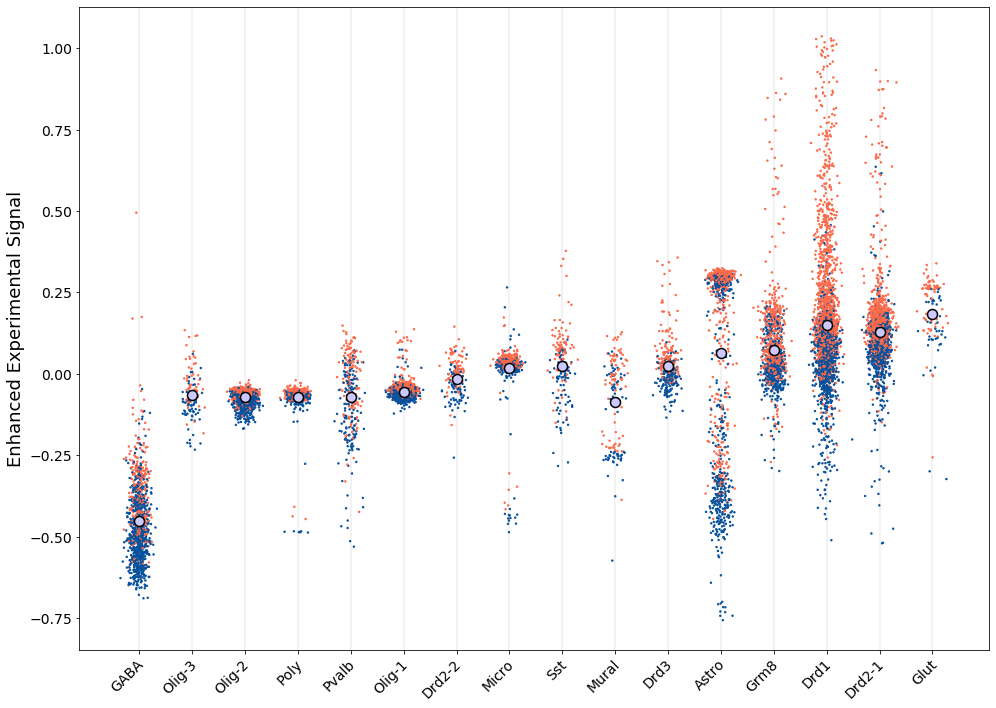

In [16]:
fig, ax = plt.subplots(1, figsize=(14,10))
plot_EES_in_clusters(ax, clusters=metadata['clusterID'], EES=metadata['EES'], c=samples_cvec)

cluster_labels = metadata.groupby('cluster').aggregate({'RES':np.mean}).sort_values('RES').index.values

ax.set_xticks(np.arange(len(cluster_labels)))
ax.set_xticklabels(cluster_labels, rotation=45, ha='right', fontsize=14)

scprep.plot.utils.shift_ticklabels(ax.xaxis, dx=0.1)

ax.set_ylabel('Enhanced Experimental Signal', fontsize=18)
ax.tick_params(labelsize=14)
fig.tight_layout()

In [17]:
#Build EES gene correlation dataframe and tables. Calculate and include Log2FC in tables.
#Note: Will give an expected divide by zero error, as we are not adding an integer to get around the log2 fold change
# divide by zero issue, which would artificially penalize lowly expressed genes.

import warnings; #these two lines will disable display of the divide by zero warning mentioned above.
warnings.filterwarnings('ignore');

cluster_list = ['Astro','Drd1','Drd2-1','Drd2-2','Drd3','GABA','Glut','Grm8',
                'Micro','Mural','Olig-1','Olig-2','Olig-3','Poly','Pvalb','Sst']

for j in cluster_list:
    cluster_name = j

    # calc logfc - un-normalize data (nonlogp1)
    is_in_cluster = metadata['cluster'] == cluster_name
    data_cluster, metadata_cluster = scprep.select.select_rows(data, metadata, idx=is_in_cluster)
    data_cluster = (np.e ** data_cluster) -1
    tx_name = 'Saline'
    is_in_tx = metadata_cluster['Stim'] == tx_name
    data_tx, metadata_tx = scprep.select.select_rows(data_cluster, metadata_cluster, idx=is_in_tx)
    tx_name = 'Cocaine'
    is_in_tx = metadata_cluster['Stim'] == tx_name
    data_tx2, metadata_tx2 = scprep.select.select_rows(data_cluster, metadata_cluster, idx=is_in_tx)

    # calc fold change (non log plus one)
    mean_veh = data_tx.mean(axis=0)
    mean_tx = data_tx2.mean(axis=0)
    FC = mean_tx / mean_veh
    FC_log = np.log2(FC)
    FC_log = FC_log.replace([np.inf, -np.inf], np.nan)
    FC_log = FC_log.dropna()
    fc_genes = FC_log.reset_index()
    fc_genes.columns = ['gene','logFC']

    # calculate pearson's r
    is_in_cluster = metadata['cluster'] == cluster_name
    data_cluster, metadata_cluster = scprep.select.select_rows(data, metadata, idx=is_in_cluster)

    gene_list = fc_genes['gene']
    gene_list = np.array(gene_list)

    fc_list = fc_genes['logFC']
    fc_list = np.array(fc_list)

    dremi_list = []
    for i in gene_list:
        value = scprep.stats.pairwise_correlation(metadata_cluster['EES'], data_cluster[i])
        dremi_list.append(value)

    # rank by pearson and build dataframe
    dremi_cluster = pd.DataFrame({'Gene':gene_list, 'r_val':dremi_list, 'log2FC':fc_list})
    dremi_cluster = dremi_cluster.sort_values(by=['r_val'], ascending=False)
    dremi_cluster['r_Rank'] = [1 * i for i in range(len(dremi_cluster))]
    dremi_cluster['r_val'] = dremi_cluster['r_val'].str[0] #remove brackets
    dremi_cluster['r_val'] = dremi_cluster['r_val'].str[0]
    
    #save cluster data
    dremi_cluster.to_csv('Data/Cocaine_'+cluster_name+'_Pearson_FC_by_Gene(no_cutoff).csv', index=False, header=True)

